# Compare quad MINOS, Gurobi, and CPLEX

Code for reproducing panels of Supplementary Figure 9

## Setup environment

In [1]:
import coralme
from coralme.builder.helper_functions import *
import pickle
import pandas
import os
import tqdm
import json
import matplotlib.pyplot as plt
import numpy as np
import sympy
pandas.set_option('display.max_colwidth', None)
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import pickle, tqdm
with open('./published/ecoli/MEModel-step2-ecoli.pkl', 'rb') as infile:
    me = pickle.load(infile)

me.add_boundary(me.metabolites.li_c, type = 'sink');

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-01
Read LP format model from file /tmp/tmpizeepre1.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpswmt7zqq.lp
Reading time = 0.01 seconds
: 1660 rows, 4754 columns, 17902 nonzeros
Read LP format model from file /tmp/tmplafz058t.lp
Reading time = 0.01 seconds
: 1810 rows, 5220 columns, 17878 nonzeros


In [3]:
me.optimize(max_mu = 1.0)
qminos = me.solution

The MINOS and quad MINOS solvers are a courtesy of Prof Michael A. Saunders. Please cite Ma, D., Yang, L., Fleming, R. et al. Reliable and efficient solution of genome-scale models of Metabolism and macromolecular Expression. Sci Rep 7, 40863 (2017). https://doi.org/10.1038/srep40863

Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	0.5000000000000000	Optimal
        2	0.7500000000000000	Optimal
        3	0.8750000000000000	Not feasible
        4	0.8125000000000000	Optimal
        5	0.8437500000000000	Not feasible
        6	0.8281250000000000	Not feasible
        7	0.8203125000000000	Not feasible
        8	0.8164062500000000	Optimal
        9	0.8183593750000000	Optimal
       10	0.8193359375000000	Not feasible
       11	0.8188476562500000	Not feasible
       12	0.8186035156250000	Optimal
       13	0.8187255859375000	Not feasible
       14	0.8186645507812500	Not feasible
       15	0.8186340332031250	Not feasible
       16	0.8186187744140625

In [4]:
me.optimize_windows(max_mu = 1.0, solver = 'cplex')
cplex = me.solution

        1	0.5000000000000000	Optimal
        2	0.7500000000000000	Optimal
        3	0.8750000000000000	Not feasible
        4	0.8125000000000000	Optimal
        5	0.8437500000000000	Not feasible
        6	0.8281250000000000	Optimal
        7	0.8359375000000000	Optimal
        8	0.8398437500000000	Not feasible
        9	0.8378906250000000	Optimal
       10	0.8388671875000000	Not feasible
       11	0.8383789062500000	Not feasible
       12	0.8381347656250000	Not feasible
       13	0.8380126953125000	Optimal
       14	0.8380737304687500	Not feasible
       15	0.8380432128906250	Not feasible
       16	0.8380279541015625	Not feasible
       17	0.8380203247070312	Optimal
       18	0.8380241394042969	Not feasible
       19	0.8380222320556641	Not feasible
       20	0.8380212783813477	Optimal


In [5]:
me.optimize_windows(max_mu = 1.0, solver = 'gurobi')
gurobi = me.solution

        1	0.5000000000000000	Optimal
        2	0.7500000000000000	Optimal
        3	0.8750000000000000	Not feasible
        4	0.8125000000000000	Optimal
        5	0.8437500000000000	Not feasible
        6	0.8281250000000000	Not feasible
        7	0.8203125000000000	Not feasible
        8	0.8164062500000000	Optimal
        9	0.8183593750000000	Optimal
       10	0.8193359375000000	Not feasible
       11	0.8188476562500000	Not feasible
       12	0.8186035156250000	Optimal
       13	0.8187255859375000	Not feasible
       14	0.8186645507812500	Not feasible
       15	0.8186340332031250	Optimal
       16	0.8186492919921875	Optimal
       17	0.8186569213867188	Optimal
       18	0.8186607360839844	Optimal
       19	0.8186626434326172	Optimal
       20	0.8186635971069336	Optimal


LinregressResult(slope=0.999354882990292, intercept=-0.012048001962485344, rvalue=0.9978476003201703, pvalue=0.0, stderr=0.0014887670257501572, intercept_stderr=0.019309367533331064)


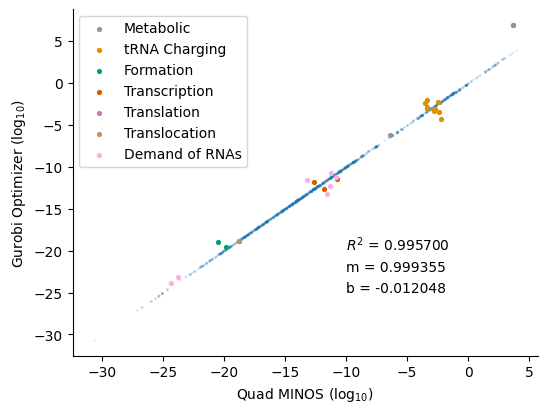

In [6]:
from scipy.stats import linregress
import seaborn

palette = seaborn.color_palette('colorblind', 10)

# concatenation will align reaction names
tmp = pandas.concat([qminos.to_frame()['fluxes'], cplex.to_frame()['fluxes'], gurobi.to_frame()['fluxes']], axis = 1)
tmp.columns = ['qminos', 'cplex', 'gurobi']

# plot non-zero fluxes only
tmp = tmp[(tmp['qminos'] != 0) & (tmp['gurobi'] != 0)]
fig, ax = plt.subplots(1, 1, figsize = (4*1.5, 3*1.5), dpi = 100)

tmp3 = tmp.apply(abs).apply(np.log)
tmp3['delta'] = tmp3['qminos'] - tmp3['gurobi']

tmp3[abs(tmp3['delta']) < 0.1].plot(kind = 'scatter', x = 'qminos', y = 'gurobi', ax = ax, alpha = .1, s = 1.)

data = tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.contains('_REV_|_FWD_') & ~tmp3.index.str.contains('dummy_reaction_FWD_SPONT')]
if data.shape[0] != 0: data.plot(kind = 'scatter', x = 'qminos', y = 'gurobi', ax = ax, s = 7.5, color = palette[7], label = 'Metabolic')

data = tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('charging')]
if data.shape[0] != 0: data.plot(kind = 'scatter', x = 'qminos', y = 'gurobi', ax = ax, s = 7.5, color = palette[1], label = 'tRNA Charging')

data = tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('formation')]
if data.shape[0] != 0: data.plot(kind = 'scatter', x = 'qminos', y = 'gurobi', ax = ax, s = 7.5, color = palette[2], label = 'Formation')

data = tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('transcription')]
if data.shape[0] != 0: data.plot(kind = 'scatter', x = 'qminos', y = 'gurobi', ax = ax, s = 7.5, color = palette[3], label = 'Transcription')

data = tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('translation')]
if data.shape[0] != 0: data.plot(kind = 'scatter', x = 'qminos', y = 'gurobi', ax = ax, s = 7.5, color = palette[4], label = 'Translation')

data = tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('translocation')]
if data.shape[0] != 0: data.plot(kind = 'scatter', x = 'qminos', y = 'gurobi', ax = ax, s = 7.5, color = palette[5], label = 'Translocation')

data = tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('DM_RNA')]
if data.shape[0] != 0: data.plot(kind = 'scatter', x = 'qminos', y = 'gurobi', ax = ax, s = 7.5, color = palette[6], label = 'Demand of RNAs')

tmp = tmp[(tmp['qminos'] != 0) & (tmp['gurobi'] != 0)]
res3 = linregress(tmp['qminos'].apply(abs).apply(np.log), tmp['gurobi'].apply(abs).apply(np.log))
print(res3)

plt.text(-10, -20, '$R^2$ = {:f}'.format(res3[2]**2))
plt.text(-10, -22.5, 'm = {:f}'.format(res3[0]))
plt.text(-10, -25, 'b = {:f}'.format(res3[1]))
    
# plt.xlim(-41, 11)
# plt.ylim(-41, 11)

ax.set_xlabel(r'Quad MINOS (log$_{10}$)')
ax.set_ylabel(r'Gurobi Optimizer (log$_{10}$)')

seaborn.despine()

plt.savefig('figures/qminos_vs_gurobi_linear_regression_log10_outliers.svg',format='SVG')

LinregressResult(slope=0.9985410309135732, intercept=-0.011661082466591921, rvalue=0.9958774721626625, pvalue=0.0, stderr=0.0024026230996100194, intercept_stderr=0.027934535773936606)


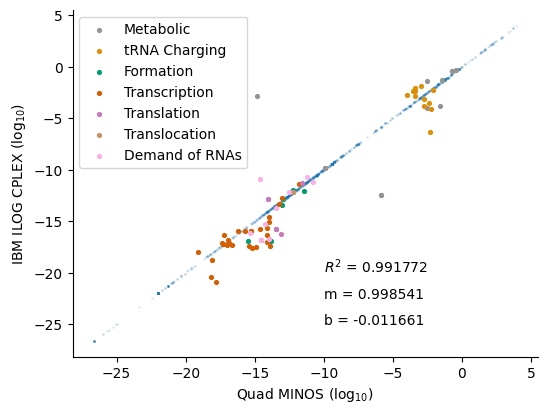

In [7]:
palette = seaborn.color_palette('colorblind', 10)

# concatenation will align reaction names
tmp = pandas.concat([qminos.to_frame()['fluxes'], cplex.to_frame()['fluxes'], gurobi.to_frame()['fluxes']], axis = 1)
tmp.columns = ['qminos', 'cplex', 'gurobi']

# plot non-zero fluxes only
tmp = tmp[(tmp['qminos'] != 0) & (tmp['cplex'] != 0)]
fig, ax = plt.subplots(1, 1, figsize = (4*1.5, 3*1.5), dpi = 100)

tmp3 = tmp.apply(abs).apply(np.log)
tmp3['delta'] = tmp3['qminos'] - tmp3['cplex']

tmp3[abs(tmp3['delta']) < 0.1].plot(kind = 'scatter', x = 'qminos', y = 'cplex', ax = ax, alpha = .1, s = 1.)

data = tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.contains('_REV_|_FWD_') & ~tmp3.index.str.contains('dummy_reaction_FWD_SPONT')]
if data.shape[0] != 0: data.plot(kind = 'scatter', x = 'qminos', y = 'cplex', ax = ax, s = 7.5, color = palette[7], label = 'Metabolic')

data = tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('charging')]
if data.shape[0] != 0: data.plot(kind = 'scatter', x = 'qminos', y = 'cplex', ax = ax, s = 7.5, color = palette[1], label = 'tRNA Charging')

data = tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('formation')]
if data.shape[0] != 0: data.plot(kind = 'scatter', x = 'qminos', y = 'cplex', ax = ax, s = 7.5, color = palette[2], label = 'Formation')

data = tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('transcription')]
if data.shape[0] != 0: data.plot(kind = 'scatter', x = 'qminos', y = 'cplex', ax = ax, s = 7.5, color = palette[3], label = 'Transcription')

data = tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('translation')]
if data.shape[0] != 0: data.plot(kind = 'scatter', x = 'qminos', y = 'cplex', ax = ax, s = 7.5, color = palette[4], label = 'Translation')

data = tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('translocation')]
if data.shape[0] != 0: data.plot(kind = 'scatter', x = 'qminos', y = 'cplex', ax = ax, s = 7.5, color = palette[5], label = 'Translocation')

data = tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('DM_RNA')]
if data.shape[0] != 0: data.plot(kind = 'scatter', x = 'qminos', y = 'cplex', ax = ax, s = 7.5, color = palette[6], label = 'Demand of RNAs')

tmp = tmp[(tmp['qminos'] != 0) & (tmp['cplex'] != 0)]
res3 = linregress(tmp['qminos'].apply(abs).apply(np.log), tmp['cplex'].apply(abs).apply(np.log))
print(res3)

plt.text(-10, -20, '$R^2$ = {:f}'.format(res3[2]**2))
plt.text(-10, -22.5, 'm = {:f}'.format(res3[0]))
plt.text(-10, -25, 'b = {:f}'.format(res3[1]))
    
# plt.xlim(-36, 11)
# plt.ylim(-36, 11)

ax.set_xlabel(r'Quad MINOS (log$_{10}$)')
ax.set_ylabel(r'IBM ILOG CPLEX (log$_{10}$)')

seaborn.despine()

plt.savefig('figures/qminos_vs_cplex_linear_regression_log10_outliers.svg',format='SVG')